In [418]:
import numpy as np
import pandas as pd

### 1. Найти данные для кластеризации. Данные в группе не должны повторяться!
### Внимание, если признаки в данных имеют очень сильно разные масштабы, то необходимо данные предварительно нормализовать.

In [419]:
data = pd.read_csv('insurance.csv', sep=',')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [420]:
from sklearn import preprocessing
data.sex.replace({'male': 1, 'female': 0}, inplace=True)
data.smoker.replace({'yes': 1, 'no': 0}, inplace=True)
data.region.replace({'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3}, inplace=True)
scaler = preprocessing.MinMaxScaler()
data.charges = scaler.fit_transform(pd.DataFrame(data.charges))
data_reshaped = data
data_reshaped.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,0,0.251611
1,18,1,33.770,1,0,1,0.009636
2,28,1,33.000,3,0,1,0.053115
3,33,1,22.705,0,0,2,0.333010
4,32,1,28.880,0,0,2,0.043816


### 2. Провести кластеризацию данных с помощью алгоритма k-means.
### Использовать «правило локтя» и коэффициент силуэта для поиска оптимального количества кластеров.

In [421]:
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

models = []
score1 = []
score2 = []
max_clusters = 10
times = []
for i in range(2, max_clusters):
    means_model = KMeans(n_clusters=i, random_state=123, init='k-means++')
    start_time = datetime.now()
    means_model.fit(data_reshaped)
    fit_time = datetime.now() - start_time
    models.append(means_model)
    score1.append(means_model.inertia_)
    score2.append(silhouette_score(data_reshaped, means_model.labels_))
    times.append(fit_time)
avg_time_means = pd.Series(times).mean()

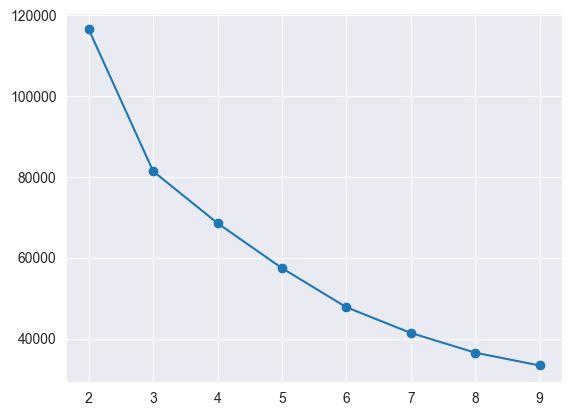

In [422]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.grid(True)
ax.set_xticks(range(max_clusters))
plt.plot(np.arange(2, max_clusters), score1, marker='o');

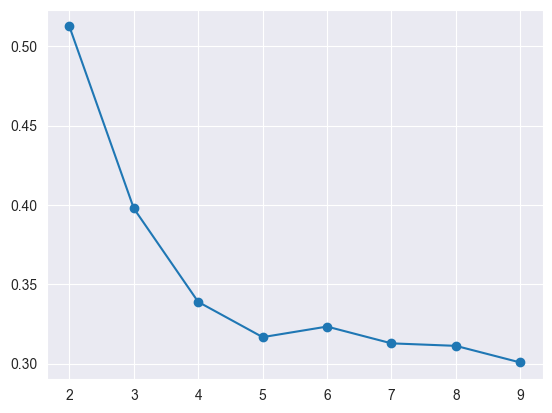

In [423]:
fig, ax = plt.subplots()
plt.grid(True)
ax.set_xticks(range(max_clusters))
plt.plot(np.arange(2, max_clusters), score2, marker='o');

In [424]:
best_model_means = models[4]

### 3. Провести кластеризацию данных с помощью алгоритма иерархической кластеризации.

In [425]:
from sklearn.cluster import AgglomerativeClustering
model2 = AgglomerativeClustering(6, compute_distances=True)
start_time = datetime.now()
clastering = model2.fit(data_reshaped)
fit_time_clastering = datetime.now() - start_time

### 4. Провести кластеризацию данных с помощью алгоритма DBSCAN.

In [426]:
from sklearn.cluster import DBSCAN
start_time = datetime.now()
model3 = DBSCAN(eps=3, min_samples=30).fit(data_reshaped)
fit_time_dbscan = datetime.now() - start_time

### 5. Сравнить скорость работы алгоритмов. Результаты изобразить в виде таблицы.

In [427]:
df_times = pd.DataFrame({'k-means': [avg_time_means], 'clastering': [fit_time_clastering], 'dbscan': [fit_time_dbscan]})
df_times

,k-means,clastering,dbscan
0,0 days 00:00:00.065076,0 days 00:00:00.018948,0 days 00:00:00.012964


### 6. Визуализировать кластеризованные данные с помощью t-SNE или UMAP если данные многомерные.
### Если данные трехмерные, то можно использовать трехмерный точечный график.

In [428]:
from sklearn.manifold import TSNE
import seaborn as sns

def t_sne_preproc(perp: int):
    tsne = TSNE(init='random', n_components=2, perplexity=perp, random_state=123, learning_rate='auto')
    tsne_features = tsne.fit_transform(data_reshaped)
    return tsne_features


def draw_plot(data, labels, tsne_features):
    plt_data = data.copy()
    plt_data['x'] = tsne_features[:, 0]
    plt_data['y'] = tsne_features[:, 1]
    g = sns.scatterplot(x='x', y='y', hue=labels, data=plt_data)
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

features = t_sne_preproc(100)

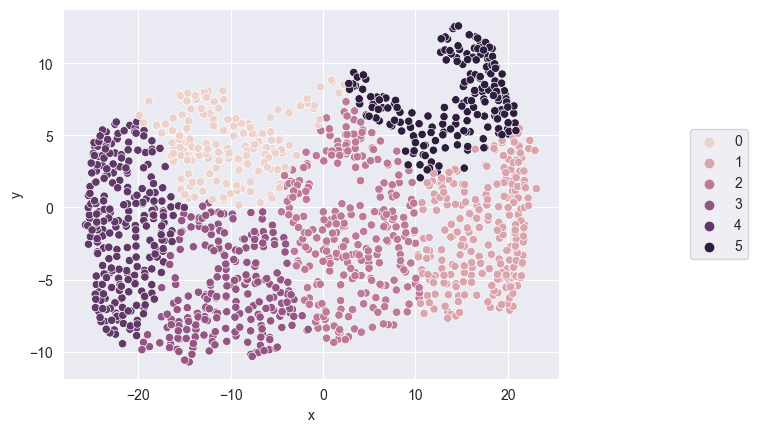

In [429]:
draw_plot(data_reshaped, best_model_means.labels_, features)

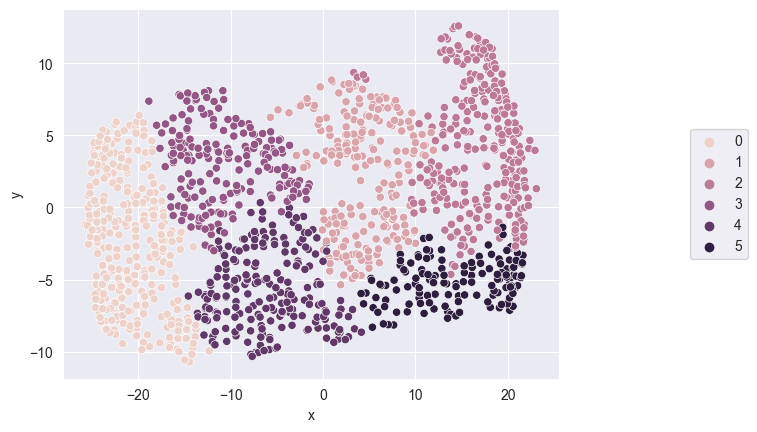

In [430]:
draw_plot(data_reshaped, clastering.labels_, features)

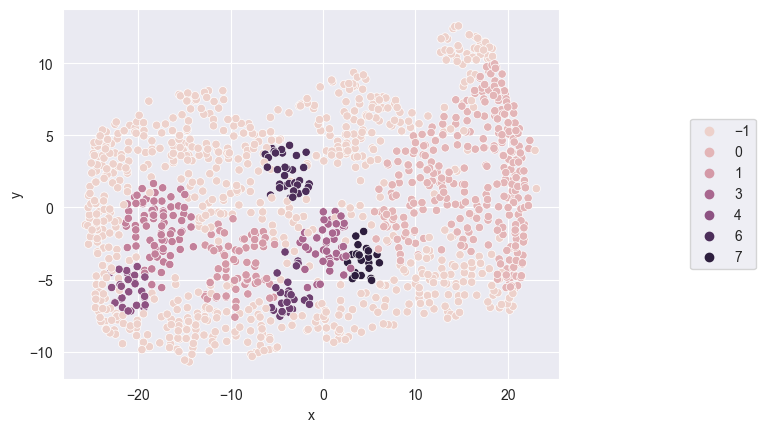

In [431]:
draw_plot(data_reshaped, model3.labels_, features)